In [1]:
from numpy import array
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense,Input
import matplotlib.pyplot as plt
from src.functions_torch import TransformLag
from src.feature import TimeConfig
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
import numpy as np


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


In [3]:
dff= pd.read_csv('../Data/apple.csv')

In [4]:
dff

,Date,Close/Last,Volume,Open,High,Low
0,05/29/2024,$190.29,53068020,$189.61,$192.247,$189.51
1,05/28/2024,$189.99,52280050,$191.51,$193.00,$189.10
2,05/24/2024,$189.98,36326980,$188.82,$190.58,$188.0404
3,05/23/2024,$186.88,51005920,$190.98,$191.00,$186.625
4,05/22/2024,$190.90,34648550,$192.265,$192.8231,$190.27
...,...,...,...,...,...,...
2512,06/05/2014,$23.1197,303186119,$23.0786,$23.1918,$22.9504
2513,06/04/2014,$23.0293,334940906,$22.7657,$23.1389,$22.7182
2514,06/03/2014,$22.7693,292173443,$22.445,$22.8122,$22.4375
2515,06/02/2014,$22.4518,368718413,$22.6414,$22.6725,$22.2322


In [5]:
timec= TimeConfig()
df= timec.process_chain(path='../Data/apple.csv',columns=['Close/Last'])

In [6]:
df

,Value
Date,
2014-05-30,22.6072
2014-06-02,22.4518
2014-06-03,22.7693
2014-06-04,23.0293
2014-06-05,23.1197
...,...
2024-05-22,190.9000
2024-05-23,186.8800
2024-05-24,189.9800


In [7]:
df= df.loc['2023':'2024'].copy()

In [8]:
timef= TransformLag()
data= timef.lag_transform(df,5)

In [9]:
data= data.to_numpy()
data

array([[130.73, 130.15, 129.62, 125.02, 126.36, 125.07],
       [133.49, 130.73, 130.15, 129.62, 125.02, 126.36],
       [133.41, 133.49, 130.73, 130.15, 129.62, 125.02],
       ...,
       [189.98, 186.88, 190.9 , 192.35, 191.04, 189.87],
       [189.99, 189.98, 186.88, 190.9 , 192.35, 191.04],
       [190.29, 189.99, 189.98, 186.88, 190.9 , 192.35]])

In [10]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)

In [11]:
from copy import deepcopy as dc
import numpy as np

In [12]:
split_index= int(len(data)*0.90)
X= transformed[:,1:]
y= transformed[:,0]
X= dc(np.flip(X,axis=1))

In [13]:
y.shape

(506,)

In [14]:
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]
X_train= X_train.reshape((-1,5,1))
X_test= X_test.reshape((-1,5,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))

In [15]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((455, 5, 1), (51, 5, 1), (455, 1), (51, 1))

In [16]:
seed=42
tf.random.set_seed(seed)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [18]:
model = Sequential()
model.add(InputLayer(shape=(5, 1)))  # Specify the input shape
model.add(LSTM(50, activation='tanh'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='linear'))
model.summary()
cp= ModelCheckpoint('model.keras',save_best_only=True)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01),metrics=[RootMeanSquaredError()])
history= model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=10,callbacks=[cp,early_stopping],batch_size=32,verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,065 (47.13 KB)

 Trainable params: 12,065 (47.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1803 - root_mean_squared_error: 0.4097 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0809 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.005

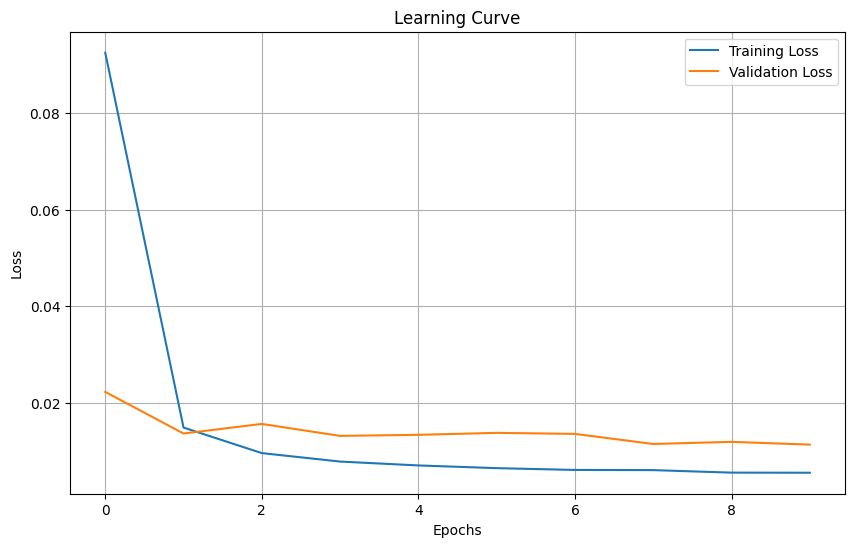

In [19]:
# Extract loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#- This is the process from Jason Brownlee in his book Machine Learning Mastery for a vanilla LSTM in TensorFlow

# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		end_ix = i + n_steps
# 		if end_ix > len(sequence)-1:
# 			break
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# n_steps = 3

# X, y = split_sequence(raw_seq, n_steps)

# n_features = 1
# X = X.reshape((X.shape[0], X.shape[1], n_features))

# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# model.fit(X, y, epochs=200, verbose=0)

# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)

# print(yhat)